In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from collections import namedtuple
import pandas as pd
import torch
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
from gpytorch.utils.memoize import cached
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import tqdm
import utils as utils

base_dir = os.path.join(os.getcwd(), '../..')
sys.path.append(base_dir)

from src.fair import forward
from src.fair.ancil import get_gas_params, get_thermal_params
from src.fair.tools import step_I, step_kernel
from src.preprocessing import load_emissions_dataset, load_response_dataset
from src.models import ThermalBoxesGP

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

<IPython.core.display.Javascript object>

In [3]:
train_scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
test_scenarios = ['historical', 'ssp245']
scenarios = train_scenarios + test_scenarios
inputs = {key: load_emissions_dataset(f'../../data/inputs_{key}.nc') for key in scenarios}
outputs = {key: load_response_dataset(f'../../data/outputs_{key}.nc') for key in scenarios}

In [4]:
def make_time_series(scenarios):
    times = dict()
    cum_emissions = dict()
    emissions = dict()
    tass = dict()
    for key in scenarios:
        time, cum_emission, emission, tas = utils.extract_arrays(inputs[key], outputs[key])
        times.update({key: time})
        cum_emissions.update({key: cum_emission})
        emissions.update({key: emission})
        tass.update({key: tas})
    ts = utils.make_emissions_timeseries(times, emissions, tass)
    stacked_ts = utils.make_stacked_emissions_timeseries(ts)
    return ts, stacked_ts

In [5]:
ts, stacked_ts = make_time_series(train_scenarios)
test_ts, test_stacked_ts = make_time_series(test_scenarios)

# Compute mean and stddev
data = torch.cat([e[ts.slices[key]] for (key, e) in ts.emissions.items()])
mu = data.mean(dim=0)
sigma = data.std(dim=0)

# Hacky way to remove historical scenario from test data for now
del test_ts.times['historical']
del test_ts.emissions['historical']
del test_ts.slices['historical']
del test_ts.tas['historical']
test_ts = test_ts._replace(scenarios=test_ts.times.keys)

In [140]:
k1 = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3])
k2 = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3])
k3 = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3])
base_kwargs = utils.get_fair_params()
d = base_kwargs['d']
q = base_kwargs['q']

In [141]:
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(timeseries=ts,
                       kernels=[k1, k2, k3],
                       likelihood=likelihood,
                       q=q, d=d)

In [142]:
# Find optimal model hyperparameters
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 60
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    output = model()
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

Iter:   0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [145]:
def get_lengthscales_df(model):
    lengthscales = torch.cat([k.lengthscale.detach() for k in model.kernels])
    data = lengthscales.numpy()
    columns = ['CO2', 'CH4', 'SO2', 'BC']
    index = [1, 2, 3]
    return pd.DataFrame(data=data, columns=columns, index=index).rename_axis('Box')
get_lengthscales_df(model)

,0
Box,
1,0.033813
2,2.894892
3,0.693147


In [146]:
model = model.eval()
with torch.no_grad():
    pred = model(test_ts)
    noisy_pred = likelihood(pred)

In [147]:
test_times = test_ts.times['ssp245'][test_ts.slices['ssp245']]
test_tas = test_ts.tas['ssp245'][test_ts.slices['ssp245']]

_, test_means = utils.compute_mean(test_ts)
test_tas_fair = test_means['ssp245'].sum(dim=-1)

with torch.no_grad():
    test_prior = model.forward(test_ts)
    noisy_test_prior = likelihood(test_prior)

prior_mean = noisy_test_prior.mean + test_tas_fair
prior_lb, prior_ub = noisy_test_prior.confidence_region()
prior_lb = prior_lb + test_tas_fair
prior_ub = prior_ub + test_tas_fair

posterior_mean = noisy_pred.mean + test_tas_fair
posterior_lb, posterior_ub = noisy_pred.confidence_region()
posterior_lb = posterior_lb + test_tas_fair
posterior_ub = posterior_ub + test_tas_fair

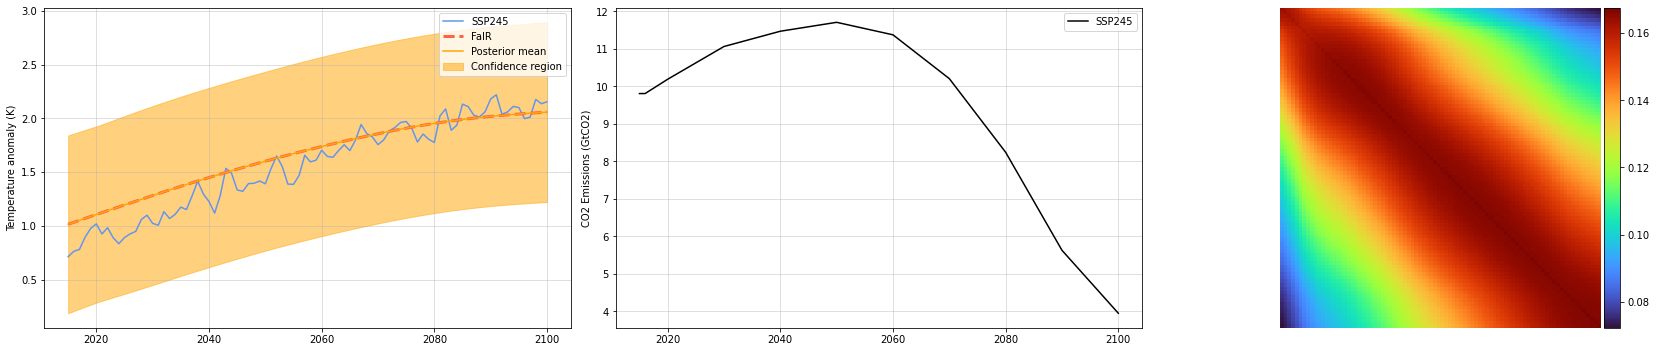

In [148]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))


ax[0].plot(test_times, test_tas, color='cornflowerblue', label='SSP245')
ax[0].set_ylabel('Temperature anomaly (K)')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=3, label='FaIR')
ax[0].plot(test_times, prior_mean, color='orange', label='Posterior mean')
ax[0].fill_between(test_times, prior_lb, prior_ub, alpha=0.5, color='orange', label='Confidence region')
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].plot(test_times, test_ts.emissions['ssp245'][test_ts.slices['ssp245'], 0], label='SSP245', color='k')
ax[1].set_ylabel('CO2 Emissions (GtCO2)')
ax[1].grid(alpha=0.5)
ax[1].legend()

im = ax[2].imshow(test_prior.covariance_matrix, cmap='turbo')
colorbar(im)
ax[2].axis('off')

plt.tight_layout()
plt.show()

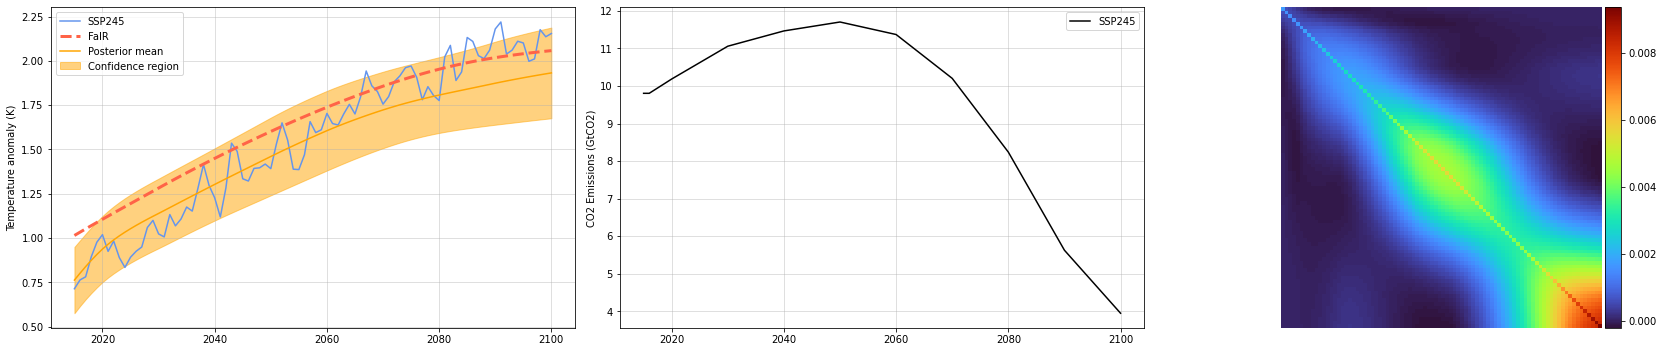

In [149]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))

ax[0].plot(test_times, test_tas, color='cornflowerblue', label='SSP245')
ax[0].set_ylabel('Temperature anomaly (K)')
ax[0].plot(test_times, test_tas_fair, color='tomato', ls='--', lw=3, label='FaIR')
ax[0].plot(test_times, posterior_mean, color='orange', label='Posterior mean')
ax[0].fill_between(test_times, posterior_lb, posterior_ub, alpha=0.5, color='orange', label='Confidence region')
ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].plot(test_times, test_ts.emissions['ssp245'][test_ts.slices['ssp245'], 0], label='SSP245', color='k')
ax[1].set_ylabel('CO2 Emissions (GtCO2)')
ax[1].grid(alpha=0.5)
ax[1].legend()


im = ax[2].imshow(pred.covariance_matrix, cmap='turbo')
colorbar(im)
ax[2].axis('off')

plt.tight_layout()
plt.show()

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/torch/distributions/distribution.py:151: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


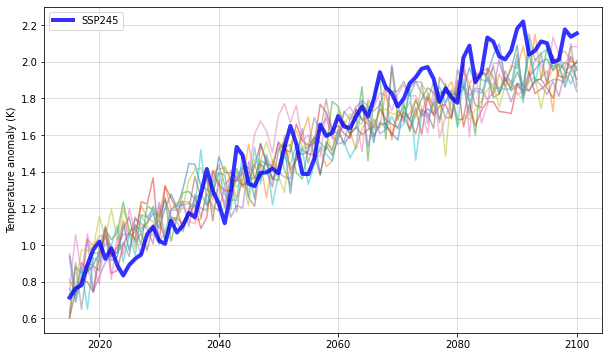

In [150]:
torch.random.manual_seed(5)
draws = noisy_pred.sample_n(10)
draws = draws + test_tas_fair

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_ylabel('Temperature anomaly (K)')
for draw in draws:
    ax.plot(test_times, draw, alpha=0.5)
ax.plot(test_times, test_tas, color='blue', label='SSP245', lw=4, alpha=0.8)
ax.grid(alpha=0.5)
plt.legend()
plt.show()